In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [5]:
dataset = pd.read_csv('../secondMMRintData/FirstPoolTest.csv')

In [6]:
dataset.head()

,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,...,EMfracstdouter,EPstdouter,MMRstrengthouter,twoMMRstrengthouter,MEGNO,MEGNOstd,prelimStable,Stable,instability_time,shadow_instability_time
0,0,0.221502,0.017511,0.002935,0.104761,0.010371,0.300893,0.085965,0.011956,0.086689,...,0.039301,0.011898,1.283409,0.000000,1.942393,0.032212,True,False,1.235665e+07,8.315223e+07
1,1,0.190647,0.073477,0.011405,0.048077,0.032956,0.403777,0.005775,0.000461,0.156924,...,0.030466,0.010790,0.000314,0.000000,22.918673,7.372319,True,False,1.348749e+05,2.133072e+05
2,2,0.125660,0.034270,0.001506,0.626885,0.228420,0.720557,0.016427,0.008207,0.000995,...,0.013904,0.009609,0.000262,0.000029,11.884854,3.404385,True,False,1.276428e+04,9.321863e+03
3,3,0.216684,0.008561,0.002451,0.012940,0.000017,0.235460,0.003955,0.000146,0.025476,...,0.001251,0.001135,0.000247,0.000179,2.000019,0.001839,True,True,1.000000e+09,1.000000e+09
4,4,0.024455,NaN,NaN,NaN,NaN,0.034058,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,8.791890e+01,8.791890e+01


In [7]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [8]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 5.98 s, sys: 47.6 ms, total: 6.03 s
Wall time: 6.03 s


In [9]:
dataset

,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,...,EPstdouter,MMRstrengthouter,twoMMRstrengthouter,MEGNO,MEGNOstd,prelimStable,Stable,instability_time,shadow_instability_time,hasnull
0,0,0.221502,0.017511,0.002935,0.104761,0.010371,0.300893,0.085965,0.011956,0.086689,...,0.011898,1.283409,0.000000,1.942393,0.032212,True,False,1.235665e+07,8.315223e+07,0
1,1,0.190647,0.073477,0.011405,0.048077,0.032956,0.403777,0.005775,0.000461,0.156924,...,0.010790,0.000314,0.000000,22.918673,7.372319,True,False,1.348749e+05,2.133072e+05,0
2,2,0.125660,0.034270,0.001506,0.626885,0.228420,0.720557,0.016427,0.008207,0.000995,...,0.009609,0.000262,0.000029,11.884854,3.404385,True,False,1.276428e+04,9.321863e+03,0
3,3,0.216684,0.008561,0.002451,0.012940,0.000017,0.235460,0.003955,0.000146,0.025476,...,0.001135,0.000247,0.000179,2.000019,0.001839,True,True,1.000000e+09,1.000000e+09,0
4,4,0.024455,NaN,NaN,NaN,NaN,0.034058,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,8.791890e+01,8.791890e+01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.049940,0.016289,0.608276,0.024447,0.664222,0.031330,0.003745,0.000864,...,0.000199,0.009017,0.002382,1.998822,0.003453,True,False,6.990387e+05,8.267916e+05,0
138539,138539,0.251338,0.016063,0.002925,0.252494,0.001243,0.272822,0.002159,0.000486,0.016379,...,0.007186,0.171046,0.000000,2.487767,0.188649,True,False,3.075749e+08,6.576003e+08,0
138540,138540,0.131799,0.027892,0.001453,0.659321,0.032653,0.366664,0.067070,0.020456,0.059567,...,0.003059,0.074479,0.000087,7.134970,1.931917,True,False,1.193822e+07,3.363291e+07,0
138541,138541,0.209454,0.090838,0.010214,1.436775,0.052453,0.395073,0.102280,0.038515,0.039390,...,0.055396,0.001822,0.001788,2.117164,0.088393,True,False,2.064407e+08,4.316851e+07,0


In [10]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','twoMMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','twoMMRstrengthfar']
outer = ['EMcrossouter', 'EMfracstdouter', 'EPstdouter', 'MMRstrengthouter','twoMMRstrengthouter']
megno = ['MEGNO', 'MEGNOstd']
#what is being used to train
features = near + far + outer + megno
pfeatures = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','MEGNO', 'MEGNOstd']
Oldfeatures = near + far + megno

In [11]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [12]:
scrambled = filtData.sample(frac=1)

In [13]:
scrambled = scrambled.reset_index()

In [14]:
scrambled

,level_0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,...,EPstdouter,MMRstrengthouter,twoMMRstrengthouter,MEGNO,MEGNOstd,prelimStable,Stable,instability_time,shadow_instability_time,hasnull
0,29146,29146,0.158502,0.055119,0.007210,0.184785,0.003397,0.587569,0.014207,0.004752,...,0.003123,0.076330,7.158848e-04,1.912579,0.050631,True,True,1.000000e+09,1.000000e+09,0
1,96719,96719,0.211732,0.020636,0.000507,3.443974,0.010050,0.246957,0.174952,0.015819,...,0.002204,0.000919,6.769019e-04,13.130106,3.580645,True,False,6.791526e+05,6.577231e+05,0
2,21089,21089,0.264486,0.003716,0.001567,0.013043,0.010472,0.492099,0.000437,0.000359,...,0.001606,0.000016,4.136733e-08,2.000075,0.000172,True,True,1.000018e+09,1.000018e+09,0
3,131930,131930,0.317119,0.004953,0.000251,0.103124,0.000279,0.405750,0.011853,0.000371,...,0.014616,0.000741,3.522445e-06,1.989736,0.002627,True,True,1.000000e+09,1.000000e+09,0
4,67115,67115,0.153640,0.035276,0.000660,0.108010,0.024842,0.211927,0.012310,0.000095,...,0.025856,0.014265,1.937967e-03,12.350419,3.241913,True,False,1.722478e+06,7.206416e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123599,105001,105001,0.251425,0.081447,0.004401,2.635335,0.026668,0.400698,0.024416,0.002776,...,0.038402,0.024970,2.420609e-03,1.983536,0.010835,True,False,1.202353e+05,1.361346e+05,0
123600,65092,65092,0.051789,0.239395,0.002878,0.130556,0.031568,0.086990,0.126844,0.002052,...,0.002037,0.021111,1.168830e-02,123.186889,32.748130,True,False,4.146024e+04,3.675935e+04,0
123601,19488,19488,0.220808,0.000917,0.000093,0.008392,0.000240,0.336025,0.000453,0.000026,...,0.000289,0.002312,0.000000e+00,1.999668,0.000163,True,True,1.000000e+09,1.000000e+09,0
123602,60942,60942,0.251492,0.048723,0.000468,0.380667,0.002427,0.454586,0.025124,0.002191,...,0.000520,0.002348,1.419858e-04,3.298186,0.463554,True,False,1.820764e+06,3.533846e+06,0


In [18]:
scrambled

,level_0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,...,EPstdouter,MMRstrengthouter,twoMMRstrengthouter,MEGNO,MEGNOstd,prelimStable,Stable,instability_time,shadow_instability_time,hasnull
0,29146,29146,0.158502,0.055119,0.007210,0.184785,0.003397,0.587569,0.014207,0.004752,...,0.003123,0.076330,7.158848e-04,1.912579,0.050631,True,True,1.000000e+09,1.000000e+09,0
1,96719,96719,0.211732,0.020636,0.000507,3.443974,0.010050,0.246957,0.174952,0.015819,...,0.002204,0.000919,6.769019e-04,13.130106,3.580645,True,False,6.791526e+05,6.577231e+05,0
2,21089,21089,0.264486,0.003716,0.001567,0.013043,0.010472,0.492099,0.000437,0.000359,...,0.001606,0.000016,4.136733e-08,2.000075,0.000172,True,True,1.000018e+09,1.000018e+09,0
3,131930,131930,0.317119,0.004953,0.000251,0.103124,0.000279,0.405750,0.011853,0.000371,...,0.014616,0.000741,3.522445e-06,1.989736,0.002627,True,True,1.000000e+09,1.000000e+09,0
4,67115,67115,0.153640,0.035276,0.000660,0.108010,0.024842,0.211927,0.012310,0.000095,...,0.025856,0.014265,1.937967e-03,12.350419,3.241913,True,False,1.722478e+06,7.206416e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123599,105001,105001,0.251425,0.081447,0.004401,2.635335,0.026668,0.400698,0.024416,0.002776,...,0.038402,0.024970,2.420609e-03,1.983536,0.010835,True,False,1.202353e+05,1.361346e+05,0
123600,65092,65092,0.051789,0.239395,0.002878,0.130556,0.031568,0.086990,0.126844,0.002052,...,0.002037,0.021111,1.168830e-02,123.186889,32.748130,True,False,4.146024e+04,3.675935e+04,0
123601,19488,19488,0.220808,0.000917,0.000093,0.008392,0.000240,0.336025,0.000453,0.000026,...,0.000289,0.002312,0.000000e+00,1.999668,0.000163,True,True,1.000000e+09,1.000000e+09,0
123602,60942,60942,0.251492,0.048723,0.000468,0.380667,0.002427,0.454586,0.025124,0.002191,...,0.000520,0.002348,1.419858e-04,3.298186,0.463554,True,False,1.820764e+06,3.533846e+06,0


In [17]:
scrambled['prelimStable'].value_counts()[True]

123604

Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [55]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]

# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [56]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [57]:
realTest = test.loc[test['prelimStable']==True]

In [58]:
realTest['Stable'].value_counts()[False]

17454

In [59]:
from sklearn.metrics import accuracy_score

In [1]:
train

NameError: name 'train' is not defined

In [61]:
OuterModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [62]:
OuterModel.fit(train[features], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [63]:
resPred = OuterModel.predict_proba(realTest[features])[:,1]
outMMRAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
outMMRacc = accuracy_score(OuterModel.predict(realTest[features]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(OuterModel.predict(realTest[features]), realTest["Stable"]))

0.9704426665786174
0.9136766312042394


In [64]:
0.9683899001604956
0.9119835231810348

0.9119835231810348

In [65]:
#OuterModel.save_model('SPOCKalt.bin')

In [66]:
0.9704634281605794
0.9129923080156361

0.9129923080156361

In [67]:
oneModel = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 20, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         scale_pos_weight=resultBalance)
oneModel.fit(train[pfeatures], train["Stable"])
resPred = oneModel.predict_proba(realTest[pfeatures])[:,1]
oneMMRAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
oneMMRacc = accuracy_score(oneModel.predict(realTest[pfeatures]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(oneModel.predict(realTest[pfeatures]), realTest["Stable"]))

0.9555836632772625
0.8885158367379961


In [68]:
print('compaired to improved model')
print(f'decrease in AOC: {((1-oneMMRAUC)-(1-outMMRAUC))/(1-oneMMRAUC)}')
print(f'decrease in error: {((1-oneMMRacc)-(1-outMMRacc))/(1-oneMMRacc)}')

compaired to improved model
decrease in AOC: 0.33453914477706903
decrease in error: 0.22568940493468828


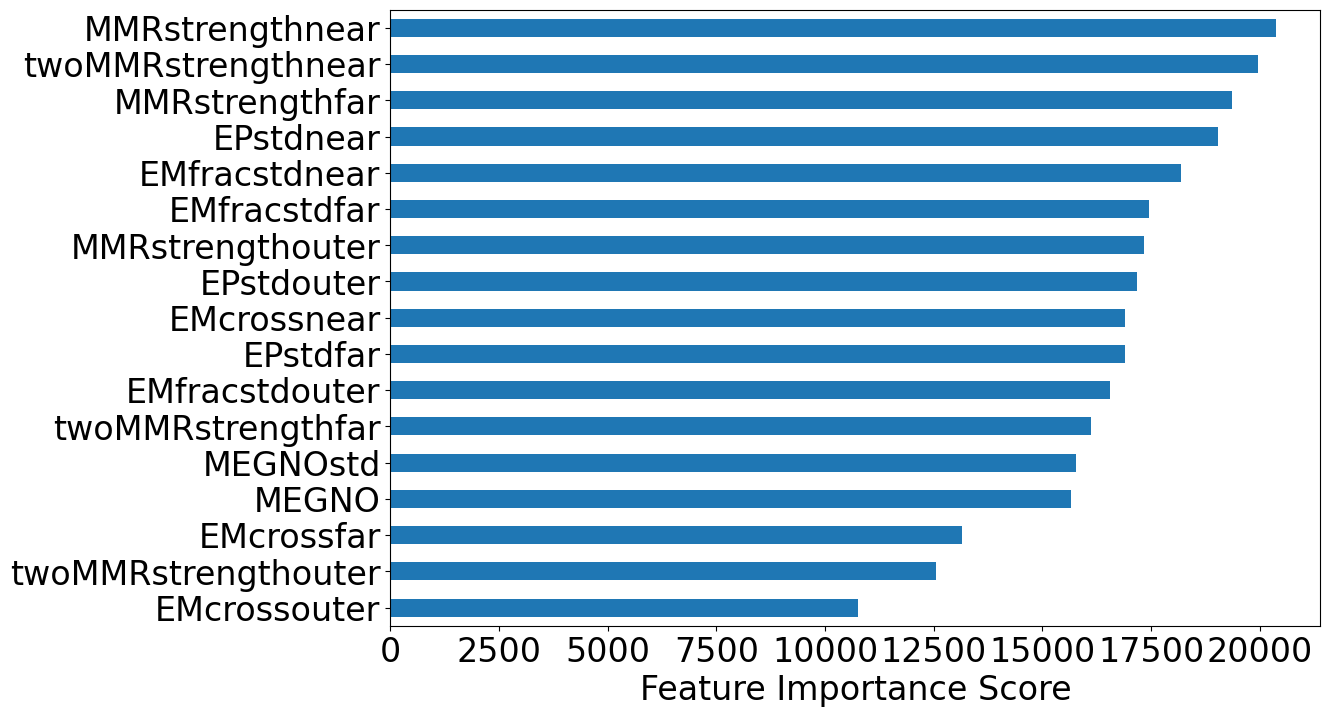

In [69]:
feat_imp = pd.Series(OuterModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [85]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [100]:
modelNN = Sequential()
modelNN.add(Dense(25, input_shape=(17,), activation = 'relu'))
#modelNN.add(Dense(50, activation='relu'))
modelNN.add(Dense(100, activation='relu'))
modelNN.add(Dense(500, activation='sigmoid'))
modelNN.add(Dense(500, activation='sigmoid'))
modelNN.add(Dense(50, activation='relu'))
modelNN.add(Dense(25, activation='sigmoid'))
modelNN.add(Dense(1, activation='sigmoid'))
modelNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

/home/miniconda3/envs/ethadhani/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [101]:
modelNN.fit(train[features], train["Stable"], validation_data=(realTest[features] , realTest['Stable']) ,epochs=300, batch_size=5500, verbose=2)


Epoch 1/300
18/18 - 0s - 27ms/step - AUC: 0.6082 - loss: 0.6504 - val_AUC: 0.8024 - val_loss: 0.5721
Epoch 2/300
18/18 - 0s - 27ms/step - AUC: 0.7899 - loss: 0.5365 - val_AUC: 0.8524 - val_loss: 0.5022
Epoch 3/300
18/18 - 0s - 27ms/step - AUC: 0.8532 - loss: 0.4784 - val_AUC: 0.8624 - val_loss: 0.4578
Epoch 4/300
18/18 - 0s - 27ms/step - AUC: 0.8657 - loss: 0.4457 - val_AUC: 0.8699 - val_loss: 0.4367
Epoch 5/300
18/18 - 0s - 27ms/step - AUC: 0.8750 - loss: 0.4261 - val_AUC: 0.8809 - val_loss: 0.4160
Epoch 6/300
18/18 - 0s - 27ms/step - AUC: 0.8900 - loss: 0.4008 - val_AUC: 0.8995 - val_loss: 0.3862
Epoch 7/300
18/18 - 0s - 27ms/step - AUC: 0.9016 - loss: 0.3732 - val_AUC: 0.9043 - val_loss: 0.3653
Epoch 8/300
18/18 - 0s - 27ms/step - AUC: 0.9060 - loss: 0.3569 - val_AUC: 0.9103 - val_loss: 0.3503
Epoch 9/300
18/18 - 0s - 27ms/step - AUC: 0.9115 - loss: 0.3451 - val_AUC: 0.9123 - val_loss: 0.3406
Epoch 10/300
18/18 - 0s - 27ms/step - AUC: 0.9158 - loss: 0.3349 - val_AUC: 0.9169 - val_lo